<a href="https://colab.research.google.com/github/b2200765028/mach-learning/blob/main/dog_cats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import torch 
import torchvision
from torch import nn
import numpy as np
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torch.nn.functional as F
from PIL import Image, ImageOps
from torchvision import transforms
import glob



In [6]:
from google.colab import drive
drive.mount("/context")


Mounted at /context


In [7]:
%cd ..
%cd context/MyDrive


/
/context/MyDrive


In [8]:
cat_paths =[]
dog_paths = []
path = "./temp/PetImages"
for url in glob.glob(path+"/Cat/*.jpg"):
  cat_paths.append(url)

print(len(cat_paths))

12499


In [9]:
path = "./temp/PetImages"
for url in glob.glob(path+"/Dog/*.jpg"):
  dog_paths.append(url)
print(len(dog_paths))


12499


In [10]:
img_paths = (cat_paths + dog_paths)
np.random.shuffle(img_paths)
print(img_paths[:10])

['./temp/PetImages/Cat/663.jpg', './temp/PetImages/Dog/1927.jpg', './temp/PetImages/Dog/1699.jpg', './temp/PetImages/Cat/3306.jpg', './temp/PetImages/Cat/12478.jpg', './temp/PetImages/Cat/9016.jpg', './temp/PetImages/Cat/9863.jpg', './temp/PetImages/Cat/1634.jpg', './temp/PetImages/Dog/7699.jpg', './temp/PetImages/Dog/5909.jpg']


In [11]:
class MyDataset(Dataset):
    def __init__(self,path,transform=None):
        
        self.path = path
        self.transform = transform
        
    def __len__(self):
        return len(self.path)
    
    def __getitem__(self,idx):
        img,label = (Image.open(self.path[idx])).convert("RGB"),self.path[idx].split("/")[-2]
        if self.transform is not None:
            img = self.transform(img)
        
        ##not sure if i have to label them this way , might change it
        if label =="Dog":
            label = torch.Tensor([1])
        else:
            label = torch.Tensor([0])
            
        sample = (img,label)

        return sample

In [12]:
class_dict = {0:"cat",1:"dog"}

In [13]:
train_transform = transforms.Compose([
     transforms.Resize((224, 224)),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
]   ## i might add more later
)

In [14]:
train_dataset = MyDataset(img_paths[:9000],train_transform)
test_dataset = MyDataset(img_paths[9000:10000],train_transform)

In [15]:
train_loader = DataLoader(train_dataset,batch_size=100,shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=100,shuffle=True)

In [16]:
batch_idx,(img,label) = next(enumerate(train_loader))

torch.Size([100, 3, 224, 224])
Label is  dog


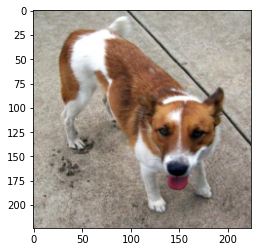

In [17]:
plt.imshow((torch.squeeze(img[5],dim=0).permute(1,2,0)))
print(img.shape)
print("Label is ", class_dict[label[5].item()])  

In [18]:
len(train_loader)

90

In [19]:
class Model(nn.Module):
    def __init__(self):
              super(Model,self).__init__()
        
              self.conv1 = nn.Sequential(
              
              nn.Conv2d(3,16,kernel_size=3, padding=0,stride=2),
              nn.BatchNorm2d(16),
              nn.ReLU(),
              nn.MaxPool2d(2),
              nn.Conv2d(16,32, kernel_size=3, padding=0, stride=2),
              nn.BatchNorm2d(32),
              nn.ReLU(),
              nn.MaxPool2d(2),
              nn.Conv2d(32,64, kernel_size=3, padding=0, stride=2),
              nn.BatchNorm2d(64),
              nn.ReLU(),
              nn.MaxPool2d(2)
            
            )

              self.linear =nn.Sequential(
                nn.Linear(3*3*64,10),
                nn.Dropout(0.2) ,
                nn.ReLU(),
                nn.Linear(10,1),

                nn.Dropout(0.2) 
            )      
            
    def forward(self,x):

        x = self.conv1(x)
        x = x.view(x.shape[0],-1)
        x = self.linear(x)

        x = torch.sigmoid(x)
        ## need it for binary
        
        return (x)

In [22]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [21]:
model = Model()
model = model.cuda()
# Define our loss function
optimizer = torch.optim.Adam(params = model.parameters(),lr=0.01)
criterion = nn.BCELoss()
next(model.parameters()).is_cuda

RuntimeError: ignored

In [ ]:
probs = model(img.cuda())
probs

In [ ]:
from tqdm import tqdm
epochs = 5
steps = 0
print_every =90
train_losses, test_losses = [], []

for e in range(epochs):
    running_loss = 0
    for images, labels in tqdm(train_loader,desc=f"Training model  epoch {e}/{epochs}"):
        steps += 1

        # Prevent accumulation of gradients
        optimizer.zero_grad()
        # Make predictions

        images, labels = images.cuda(), labels.cuda()

        
        log_ps = model(images)
     
        loss = criterion(log_ps, labels)
        
        #backprop
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0

            # Turn off gradients for validation
            with torch.no_grad():
                model.eval()
                for images, labels in test_loader:
                  
                    images, labels = images.cuda(), labels.cuda()
                    log_ps = model(images)
                    test_loss += criterion(log_ps, labels)

      
                    top_p = ((log_ps)>0.5)*1.0
                  
                    equals = top_p== labels.view(*top_p.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor))

            model.train()

            train_losses.append(running_loss/len(train_loader))
            test_losses.append(test_loss/len(test_loader))
          

            print("Epoch: {}/{}.. ".format(e+1, epochs),
                  "Training Loss: {:.3f}.. ".format(train_losses[-1]),
                  "Test Loss: {:.3f}.. ".format(test_losses[-1]),
                  "Test Accuracy: {:.3f}".format(accuracy/len(test_loader)))

In [ ]:

idx,(img,label)= next(enumerate(test_loader))
predict = model(img.cuda())

(((predict)>0.5)*1.0==label.cuda()).sum()

In [ ]:
class Cnn(nn.Module):
    def __init__(self):
        super(Cnn,self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3,16,kernel_size=3,padding=0,stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(16,32,kernel_size=3,padding=0,stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
        
        )
        
         
        self.layer3 = nn.Sequential(
            nn.Conv2d(32,64,kernel_size=3,padding=0,stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        
        )
        
        self.fc1 = nn.Linear(3*3*64,10)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(10,2)
        self.relu = nn.ReLU()
        
    def forward(self,x):
        out =self.layer1(x)
        out =self.layer2(out)
        out =self.layer3(out)
        out =out.view(out.size(0),-1)
        out =self.relu(self.fc1(out))
        out =self.fc2(out)
        return out

In [ ]:
model = Cnn().to(device)
model.train()
optimizer = torch.optim.Adam(params = model.parameters(),lr =0.001)
criterion = nn.CrossEntropyLoss()

In [ ]:
epochs = 10

for epoch in range(epochs):
    model.train()
    epoch_loss =0
    epoch_accuracy = 0
    
    for data,label in train_loader:
        data= data.to(device)
        label = label.to(device)
        
        output = model(data)
        loss = criterion(output,label)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        acc = ((output.argmax(dim=1)==label).float().mean())
        epoch_accuracy += acc/len(train_loader)
        epoch_loss += loss/len(train_loader)
        
    print('Epoch : {}, train accuracy : {}, train loss : {}'.format(epoch+1, epoch_accuracy,epoch_loss))
        
    with torch.no_grad():
        model.eval()
        epoch_val_accuracy =0
        epoch_val_loss = 0
        for data,label in  test_loader:
            data= data.to(device)
            label = label.to(device)

            val_output = model(data)
            val_loss = criterion(output,label)


            acc = ((output.argmax(dim=1)==label).sum())
            epoch_val_accuracy += acc/len(test_loader)
            epoch_val_loss += val_loss/len(test_loader)
        print('Epoch : {}, val_accuracy : {}, val_loss : {}'.format(epoch+1, epoch_val_accuracy,epoch_val_loss))
            

In [ ]:


idx,(img,label)= next(enumerate(test_loader))
predict = model(img.cuda())

(predict.argmax(dim=1)==label.cuda()).sum()